In [3]:
#pip install num2words
!pip install unidecode

In [4]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import unidecode
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes et fonctions

In [68]:
REGEX = '[a-z0-9]+[#-]?[a-z0-9]*'
DICT_COLS = {'Title': 20, 'Body': 75}
SAMPLE = 5000
RATIO = 1/3

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = tknzr.tokenize(unidecode.unidecode(col).lower())
    return ' '.join(stmr.stem(lmtzr.lemmatize(w, get_wordnet_pos(w))) \
                    for w in temp if w not in sw and not w.isdigit())

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        #liste = list(itertools.chain.from_iterable(df[col].values))
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

def tag_question(title, body):
    """
    Prediction function of stackexchange tags from a query passed as parameter
    """ 

    RATIO = 1/3
    REGEX = '[a-z0-9]+[#-]?[a-z0-9]*'

    # Stopwords nltk 
    std_sw = set(nltk.corpus.stopwords.words('english')) 

    # Extra stopwords = radicaux qui ne me semblent pas discriminants 
    extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
                'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
                'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')


    tokenizer = nltk.RegexpTokenizer(REGEX)
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer()

    with open('OC_DS_P6_prod.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        sclr = unpickler.load()
        tfidf = unpickler.load()
        mod = unpickler.load()
        lbl = unpickler.load()

    title = clean_field(title, tknzr=tokenizer, sw=std_sw, \
                        lmtzr=lemmatizer, stmr=stemmer)
    title = ' '.join([w for w in title.split() \
                       if w not in extra_sw and not w.isdigit()])

    body = clean_field(body, tknzr=tokenizer, sw=std_sw, \
                       lmtzr=lemmatizer, stmr=stemmer)
    body = ' '.join([w for w in body.split() \
                      if w not in extra_sw and not w.isdigit()])
    
    tfidf_q = tfidf['Title'].transform([title])
    cols = tfidf['Title'].get_feature_names()
    tfidf_q = pd.DataFrame(tfidf_q.todense().tolist(), columns=cols)

    tfidf_b = tfidf['Body'].transform([body])
    cols = tfidf['Body'].get_feature_names()
    tfidf_b = pd.DataFrame(tfidf_b.todense().tolist(), columns=cols)

    X = (RATIO * tfidf_q).add((1 - RATIO) * tfidf_b, fill_value=0).fillna(0)

    return '<{}>'.format('><'.\
                         join(lbl.inverse_transform(mod.predict(sclr.transform(X))).\
                                                    split()))

# Chargement

In [51]:
with open('OC_DS_P6_backup.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    train = unpickler.load()

# Etiquetage des tags
lbl = LabelEncoder()
train['Tags_lbl'] = lbl.fit_transform(train.Tags)

In [55]:
lbl.inverse_transform([12816])[0]

'c#'

In [11]:
train = train[train.nTags == 1]
train.shape

(5512, 5)

# TF-IDF
Je crée un dictionnaire avec les vecteurs TFIDF pour les appeler dans la fonction finale

In [33]:
dict_tfidf = defaultdict(dict)

for col in ['Title', 'Body']:
    X = train[col].copy()

    dict_tfidf['vector'][col] = TfidfVectorizer(token_pattern=REGEX, \
                                                min_df=DICT_COLS[col]).fit(X)
    v_tfidf = dict_tfidf['vector'][col].transform(X)
    cols = dict_tfidf['vector'][col].get_feature_names()
    dict_tfidf['df'][col] = pd.DataFrame(v_tfidf.todense().tolist(), \
                                         columns=cols, index=train.index)
    print(col, ':', dict_tfidf['df'][col].shape)
    print(cols)

Title : (5512, 300)
['access', 'action', 'add', 'allow', 'android', 'anoth', 'api', 'app', 'applic', 'argument', 'array', 'asp', 'assign', 'attribut', 'bad', 'base', 'bash', 'best', 'binari', 'block', 'branch', 'browser', 'buffer', 'build', 'button', 'c', 'c#', 'call', 'cannot', 'case', 'certain', 'chang', 'charact', 'check', 'class', 'click', 'client', 'code', 'collect', 'color', 'column', 'command', 'commit', 'compil', 'comput', 'condit', 'configur', 'connect', 'constructor', 'contain', 'content', 'control', 'convert', 'copi', 'count', 'cs', 'current', 'custom', 'data', 'databas', 'date', 'declar', 'default', 'defin', 'delet', 'depend', 'design', 'detect', 'determin', 'develop', 'differ', 'directori', 'disabl', 'display', 'div', 'document', 'domain', 'download', 'dynam', 'eclips', 'edit', 'element', 'emac', 'empti', 'end', 'entiti', 'equival', 'error', 'event', 'except', 'execut', 'exist', 'express', 'fail', 'field', 'file', 'find', 'first', 'folder', 'form', 'format', 'framework', '

# Clustering

## Title

### PCA

In [8]:
pca = decomposition.PCA(n_components=2)

X = dict_tfidf['df']['Title']

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00742094 0.00658668] 0.014007622090083428


best clustering =  600


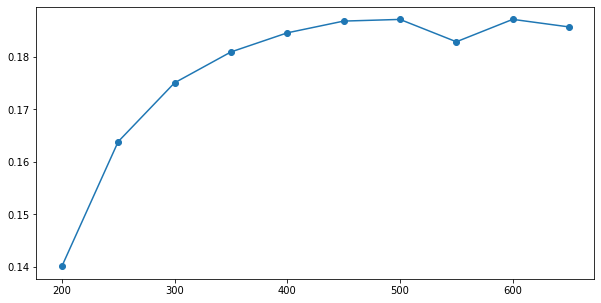

In [9]:
fig = plt.figure(figsize=(10, 5))
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(200, 700, 50)
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1)
    myclust.fit(X_scaled)
    silhouettes.append(metrics.silhouette_score(X_scaled, myclust.labels_))

plt.plot(cluster_range, silhouettes, marker='o')

best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster)

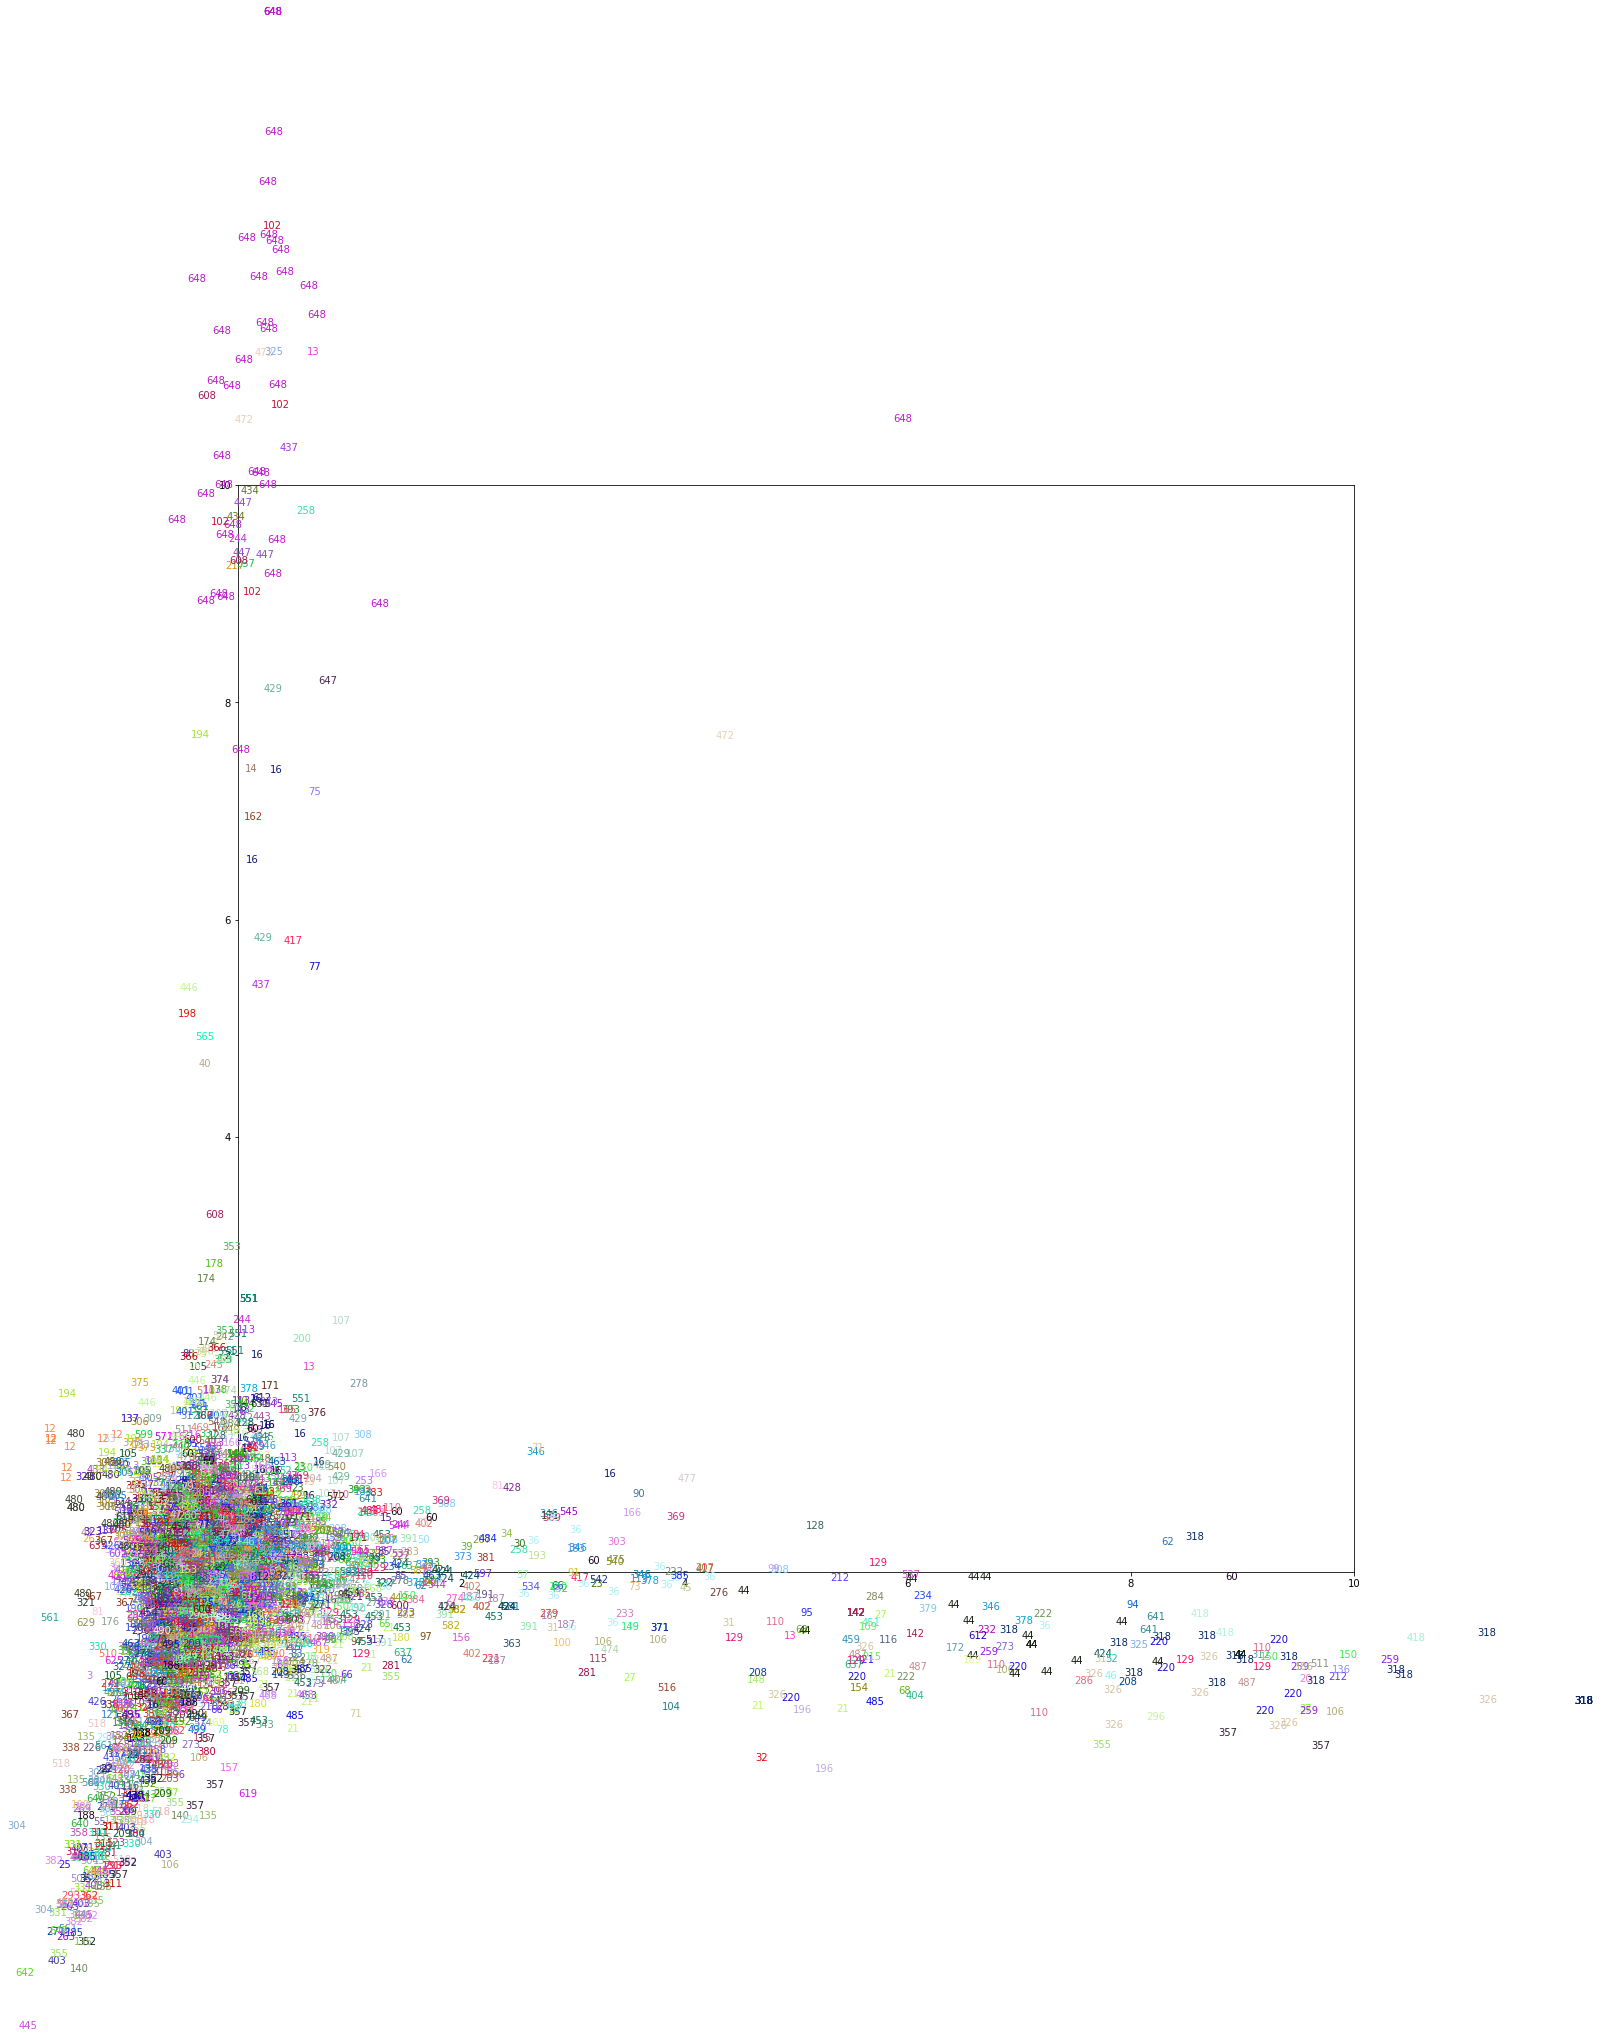

Silhouette Coefficient: 0.124


In [10]:
nb_clusters = 650
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [11]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = dict_tfidf['df']['Title'].assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649
0,2,2,2,6,5,12,20,27,11,280,17,21,9,11,19,2,17,1,5,3,14,27,17,13,22,11,16,15,14,21,5,15,18,12,11,19,22,18,1,21,...,2,1,10,1,3,1,2,2,2,10,1,1,1,1,1,1,1,6,9,1,1,13,2,1,2,2,3,7,12,1,3,3,6,1,1,17,1,1,39,1


In [12]:
tfidf[tfidf.cluster == 5][['cluster']].merge(train[['Title', 'Body', 'Tags']], left_index=True, right_index=True)

,cluster,Title,Body,Tags
17094288,5,put variabl doubl quot echo,see code anyth put variabl quot instead echo d...,php
830463,5,differ global variabl variabl main,,c++
2843388,5,jqueri selector variabl,ask selector variabl first call work fine pa v...,jquery
970274,5,class objective-c variabl,work objective-c code write found variabl decl...,objective-c
50885684,5,kotlin smart cast nullabl variabl,tri follow code error show smart cast mutablel...,kotlin
3145376,5,xform xxform variabl break xforms-alert function,follow tag form captur queri string paramet ma...,xforms
3669461,5,singleton pattern global variabl,consid follow code part time h time cpp sinc h...,c++
33361100,5,ambig type variabl variabl paramet printf-lik ...,write interpret function take function normal ...,haskell
9940695,5,typedef enum-lik variabl arbitrari increment,interest someth enum increment alway one sort ...,c
34375111,5,understand javascript scope variabl,embark mission actual explor tri deepli unders...,javascript


## Quote-part Title et Body


In [13]:
RATIO = 1/10
X = (RATIO * dict_tfidf['df']['Title']).add((1 - RATIO) * dict_tfidf['df']['Body'], \
                                            fill_value=0).fillna(0)

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

### PCA

In [14]:
pca = decomposition.PCA(n_components=2)
X_trans = pca.fit_transform(X_scaled)
print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00702508 0.00592758] 0.012952660141697107


best clustering =  200


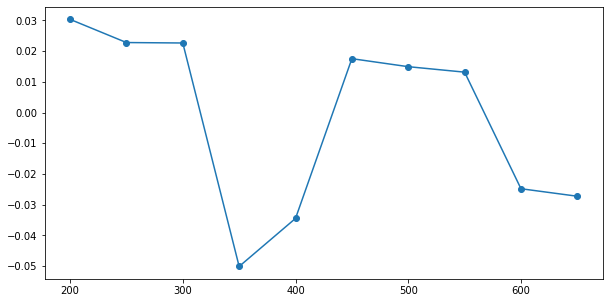

In [15]:
fig = plt.figure(figsize=(10, 5))
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(200, 700, 50)
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1)
    myclust.fit(X_scaled)
    silhouettes.append(metrics.silhouette_score(X_scaled, myclust.labels_))

plt.plot(cluster_range, silhouettes, marker='o')

best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster)

In [16]:
nb_clusters = 300

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

Silhouette Coefficient: -0.014


In [17]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = dict_tfidf['df']['Title'].assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,1,31,29,57,4,17,1,16,2,18,17,2,1,19,31,22,26,28,14,19,10,8,4,1,15,4,2,28,18,3,1,20,42,14,17,35,38,34,49,22,...,36,13,1,23,1,13,18,8,19,20,8,10,14,8,18,1,16,2,12,1,16,11,14,23,24,11,16,1,16,3,39,18,17,11,2,13,8,31,6,13


In [18]:
tfidf[tfidf.cluster == 1][['cluster']].merge(train[['Title', 'Body', 'Tags']], left_index=True, right_index=True)

,cluster,Title,Body,Tags
173378,1,anyon built web-app run total off-lin,build app author hope help uh author thing thi...,offline
555043,1,wildcard app id iphon ipod touch app,write third app alreadi app app store still ap...,iphone
2859862,1,go web app function server perspect,follow direct go abl applic work great one thi...,go
12603,1,profil provid built web app,asp net web file project direct access profil ...,asp.net
111135,1,net app run machin net runtim instal,write app v fanci stuff linq object initi etc ...,.net
457671,1,c# save runtim font set,allow user abl make font choic listview consid...,c#
164311,1,adob air app run system tray pop window,exampl write calendar app top air say flex app...,air
68150,1,long keep code,take data structur class c last year consequ i...,code-reuse
889447,1,concern core data,readi dive first core data adventur evalu fram...,core-data
10728881,1,support two shell window,write simpl explor exe altern activ switch wit...,windows-7


# Classification supervisée

In [19]:
DICT_CLF = {'knn': {'name': 'k-Nearest Neighbors',
                     'clf': KNeighborsClassifier(),
                     'params': {'n_neighbors': np.arange(100, 700, 50)}}
            }
"""
            ,
            'svm': {'name': 'Support Vector Machine',
                     'clf': LinearSVC(dual=False, multi_class='ovr') ,
                     'params': {'C': np.logspace(-3, 3, 7),
                                'loss': ['hinge','squared_hinge'],
                                'penalty': ['l1', 'l2']}},
            'rfc': {'name': 'Random Forrest',
                     'clf': RandomForestClassifier(),
                     'params': {'criterion': ['entropy', 'gini'],
                                'n_estimators': [20, 40, 60, 80, 100],
                                'max_features':['sqrt', 'log2']}},
            'adc': {'name': 'AdaBoost',
                     'clf': AdaBoostClassifier(),
                     'params': {'n_estimators': \
                                [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}},
            'gbc': {'name': 'Gradient Boosting',
                     'clf': GradientBoostingClassifier(),
                     'params': {'n_estimators': \
                                [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}}
            }
"""

"\n            ,\n            'svm': {'name': 'Support Vector Machine',\n                     'clf': LinearSVC(dual=False, multi_class='ovr') ,\n                     'params': {'C': np.logspace(-3, 3, 7),\n                                'loss': ['hinge','squared_hinge'],\n                                'penalty': ['l1', 'l2']}},\n            'rfc': {'name': 'Random Forrest',\n                     'clf': RandomForestClassifier(),\n                     'params': {'criterion': ['entropy', 'gini'],\n                                'n_estimators': [20, 40, 60, 80, 100],\n                                'max_features':['sqrt', 'log2']}},\n            'adc': {'name': 'AdaBoost',\n                     'clf': AdaBoostClassifier(),\n                     'params': {'n_estimators':                                 [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}},\n            'gbc': {'name': 'Gradient Boosting',\n                     'clf': GradientBoostingClassifier(),\n                     'params':

## Title

In [20]:
train.shape

(5512, 5)

In [21]:
col = 'Title'

y = train.Tags_lbl
X = train[col]
X_train, X_test, y_train, y_test = train_test_split(dict_tfidf[col]['vector'].\
                                                    transform(X), y, \
                                                    test_size=0.3)

std_scale = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((3858, 300), (1654, 300))

In [22]:
dict_precision = {}

for k, v in DICT_CLF.items():
    print('{}\n{}\n{}'.format('='*30, v['name'], '-'*30))
    dict_precision[v['name']] = {}

    clf = v['clf']
    start_time = timeit.default_timer()
    gs = GridSearchCV(clf, v['params'], cv=5, scoring = 'accuracy',n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    print("Best params:", gs.best_params_, '\n')
    dict_precision[v['name']]['clf'] = gs

    y_pred = gs.predict(X_test_scaled)
    precision = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    dict_precision[v['name']]['precision'] = precision
    print("Precision: {:.2f} % \n".format(precision))

    elapsed = timeit.default_timer() - start_time

    accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    print(col, ": accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

k-Nearest Neighbors
------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best params: {'n_neighbors': 200} 

Precision: 22.00 % 

Title : accuracy 22.00% time 6.93s



In [23]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print(col, "accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

Title accuracy 41.00% time 11.21s



## Title + Body

In [48]:
X = (RATIO * dict_tfidf['df']['Title']).add((1 - RATIO) * dict_tfidf['df']['Body'], \
                                            fill_value=0).fillna(0)
y = train.Tags_lbl
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    test_size=0.3)

std_scale = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((3858, 495), (1654, 495))

In [17]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

accuracy 46.00% time 25.50s



In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern=REGEX,  
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(train.Title)
data_vectorized.shape

# LDA

In [15]:
# Regroupement des df Title et Body
ratio = 1/3
titles = dict_tfidf['df']['Title'][:SAMPLE]
bodies = dict_tfidf['df']['Body'][:SAMPLE]

X = (ratio * titles).add((1 - ratio) * bodies, fill_value=True).fillna(0)
y = train.Tags_lbl[:SAMPLE]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((3500, 495), (1500, 495))

In [ ]:
#instantiate CountVectorizer() 
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
TF_Title=cv.fit_transform(train_1T.Title)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 50

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(TF_Title)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tfidf.columns[:-1], no_top_words)

# Export

In [56]:
with open('OC_DS_P6_prod.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(std_scale)
    pickler.dump(dict_tfidf['vector'])
    pickler.dump(gs)
    pickler.dump(lbl)    

# Test

In [57]:
std_sw = set(nltk.corpus.stopwords.words('english')) 

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')


tokenizer = nltk.RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

with open('OC_DS_P6_prod.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    sclr = unpickler.load()
    tfidf = unpickler.load()
    mod = unpickler.load()
    lbl = unpickler.load()

In [ ]:
tag_question('track 3rd parti code git', 'seem grok differ solut found studi track exter')

In [64]:
train[train.Tags.str.contains('emacs')]

,Title,Body,Tags,nTags,Tags_lbl
9390770,node j prompt show eshel,run node j eshel prompt right fix,emacs eshell node.js,3,24757
8983758,post-command hook this-command kill-word turn ...,post-command hook callback kill-word this-comm...,elisp emacs,2,24725
10149,bind regular express key combin emac,context someth emac newbi long lot also comfor...,emacs lisp regex,3,24783
10197517,emac session client find,everi c-x c-c emac announc emac session client...,emacs,1,24749
1496,prefer version vim emac mac o,u graphic version vim emac instead consol vers...,editor emacs macos vim,4,24631
...,...,...,...,...,...
589691,emul vim search gnu emac,vim key normal mode search word cursor gnu ema...,dot-emacs elisp emacs vim,4,24110
970759,align argument function emac,say follow align argument follow m-x align-reg...,code-formatting elisp emacs,3,18819
2416655,file path clipboard emac,simpl send current full file name file path cl...,emacs,1,24749
1088387,specif product gain vim emac provid gui text e...,meant troll flamebait anyth console-editor cho...,emacs text-editor vim,3,24803
